In [60]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from epa import *
from sample_processing import *
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%autoreload 2

# Generating Random Data

In [8]:
# Set 3 clusters with different regression params
mus = [5, 0 ,5]
sds = [1, 1, 1]
n_points_per_clust = 100

betas = [np.array([-10,-3]),
         np.array([0,0]),
         np.array([-5,3])]

sigmas = [0.5,1,2]

# Generate data
Xs = []
Ys = []

for k in range(len(mus)):
    
    X_k = np.random.normal(mus[k],sds[k],n_points_per_clust)
    y_k = betas[k][0] + betas[k][1]*X_k + np.random.normal(0,sigmas[k],n_points_per_clust)
    
    Xs.append(X_k)
    Ys.append(y_k)

Xs = np.concatenate(Xs)
Ys = np.concatenate(Ys)
inds = np.array(n_points_per_clust*[0] + n_points_per_clust*[1] + n_points_per_clust*[2])

# Randomly permutate
random_perm = np.arange(len(Xs))
np.random.shuffle(random_perm)

In [9]:
col_map = ['r','b','g']

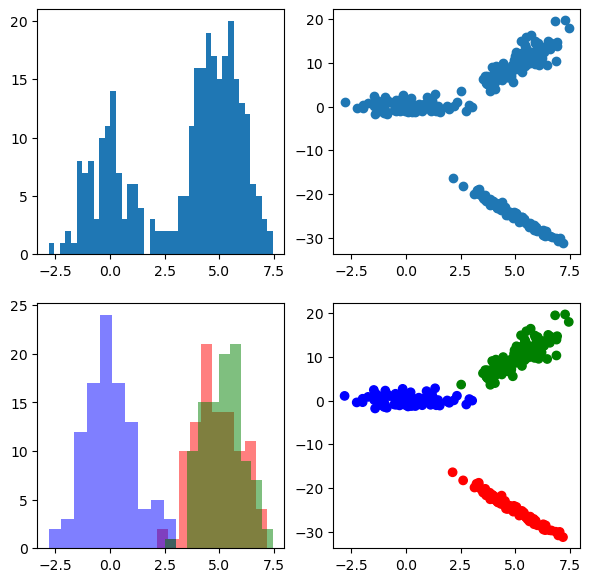

In [10]:
fig, ax = plt.subplots(2,2,figsize=(7,7))

ax[0,0].hist(Xs,bins=40)
ax[0,1].scatter(Xs,Ys)

for i in range(len(mus)):
    ax[1,0].hist(Xs[np.where(inds==i)],
                 color=col_map[i],alpha=0.5)

ax[1,1].scatter(Xs,Ys,c=[col_map[i] for i in inds])
plt.show()

# Run Gibbs Sampler

In [11]:
Xs = Xs[random_perm].reshape(-1,1)
Ys = Ys[random_perm]
Zs = Xs[random_perm]

Xs = np.hstack([np.ones(len(Xs)).reshape(-1,1),Xs])

In [16]:
# Dist mat
lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func)

# intialize 
partition_samp = np.array(100*[1]+100*[2]+100*[3])
names_used = [1,2,3]
alpha_samp = 0.05

delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(30)
np.random.shuffle(order_samp)
phi_samp = np.array([[0.5,0.5],
                     [2,2],
                     [-1,-1]])

#### gibbs sampling hyper parameters
n_gibbs = 3000
k = 300 # no. of numbers to permute order

# GRW sampler param
rw_sd = 0.2

# alpha prior
a_alpha = 1
b_alpha = 10
alpha_bounds = [0,1e99]

# delta prior
a_delta = 1
b_delta = 1
w = 0.5
delta_bounds = [0,1]

# phi / regression prior
phi_mean_prior = np.array([0,0])
phi_cov_prior = np.array([[1,0],[0,1]])
sigma_reg = 1

partition_save = []
alpha_save = []
delta_save = []
phi_save = []
log_prob_save = []

# Gibbs loop
for g in range(n_gibbs):
    if g%100 == 0:
        print("Gibbs: ", g)
        
    # Sample cluster for each i 
    for i in range(len(Ys)):

        partition_samp,phi_samp, names_used = sample_conditional_i_clust_alt(i,
                                         partition_samp,
                                         alpha_samp,
                                         delta_samp,
                                         sim_mat,
                                         order_samp,
                                         phi_samp, Ys, Xs, sigma_reg,
                                        names_used,
                                         phi_base_mean=phi_mean_prior,
                                            phi_base_cov=phi_cov_prior)
        
        #print(i)
    
    # Update phis
    phi_samp = sample_phi(phi_samp, Ys, Xs, partition_samp,
               phi_mean_prior,
               phi_cov_prior,
               sigma_reg)
    
    # Sample ordering 
    order_samp = permute_k(order_samp, k)
        
    #### Sample parameters, alpha, sigma
    """
    alpha_samp = metropolis_step_alpha(alpha_samp, rw_sd, a_alpha, b_alpha,
                         partition_samp,
                             delta_samp,
                             sim_mat,
                             order_samp,bounds=alpha_bounds)
    
    
    delta_samp = metropolis_step_delta(delta_samp, rw_sd, a_delta, b_delta, w,
                         partition_samp,
                             alpha_samp,
                             sim_mat,
                             order,bounds=delta_bounds)
    """
    alpha_samp = 0.05
    delta_samp = 0
    
    
    # Calc log prob of result
    log_prob_samp = calc_log_joint(partition=partition_samp,
                                   phi=phi_samp,
                                   y=Ys,
                                   x=Xs,
                                   sim_mat=sim_mat,
                                   order=order_samp,
                                   alpha=alpha_samp,
                                   delta=delta_samp,
                                   sigma_reg = sigma_reg)
    
    # Save sampled values
    log_prob_save.append(log_prob_samp)
    partition_save.append(partition_samp)
    alpha_save.append(alpha_samp)
    delta_save.append(delta_samp)
    phi_save.append(phi_samp)

Gibbs:  0
Gibbs:  100
Gibbs:  200
Gibbs:  300
Gibbs:  400
Gibbs:  500
Gibbs:  600
Gibbs:  700
Gibbs:  800
Gibbs:  900
Gibbs:  1000
Gibbs:  1100
Gibbs:  1200
Gibbs:  1300
Gibbs:  1400
Gibbs:  1500
Gibbs:  1600
Gibbs:  1700
Gibbs:  1800
Gibbs:  1900
Gibbs:  2000
Gibbs:  2100
Gibbs:  2200
Gibbs:  2300
Gibbs:  2400
Gibbs:  2500
Gibbs:  2600
Gibbs:  2700
Gibbs:  2800
Gibbs:  2900


# Calculating Similarity Matrix from MCMC samples

In [61]:
normalized_sim_mat = calc_hit_matrix(partition_save,
                                     burn_samples=1000,
                                     normalize=True)

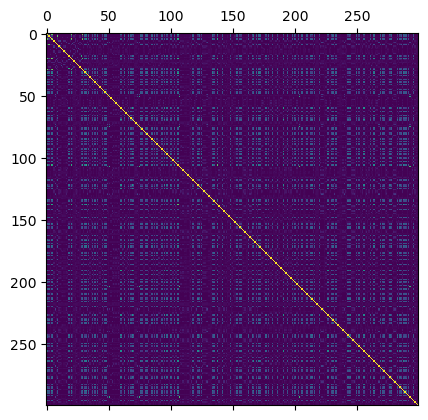

In [62]:
plt.matshow(normalized_sim_mat)
plt.show()

In [63]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=3,
                                       linkage_type='average')

In [64]:
pd.Series(agglo_cluster_solution).value_counts()

0    120
1    100
2     80
dtype: int64

In [65]:
col_map=['r', 'b', 'g','k','m','y','tab:orange']

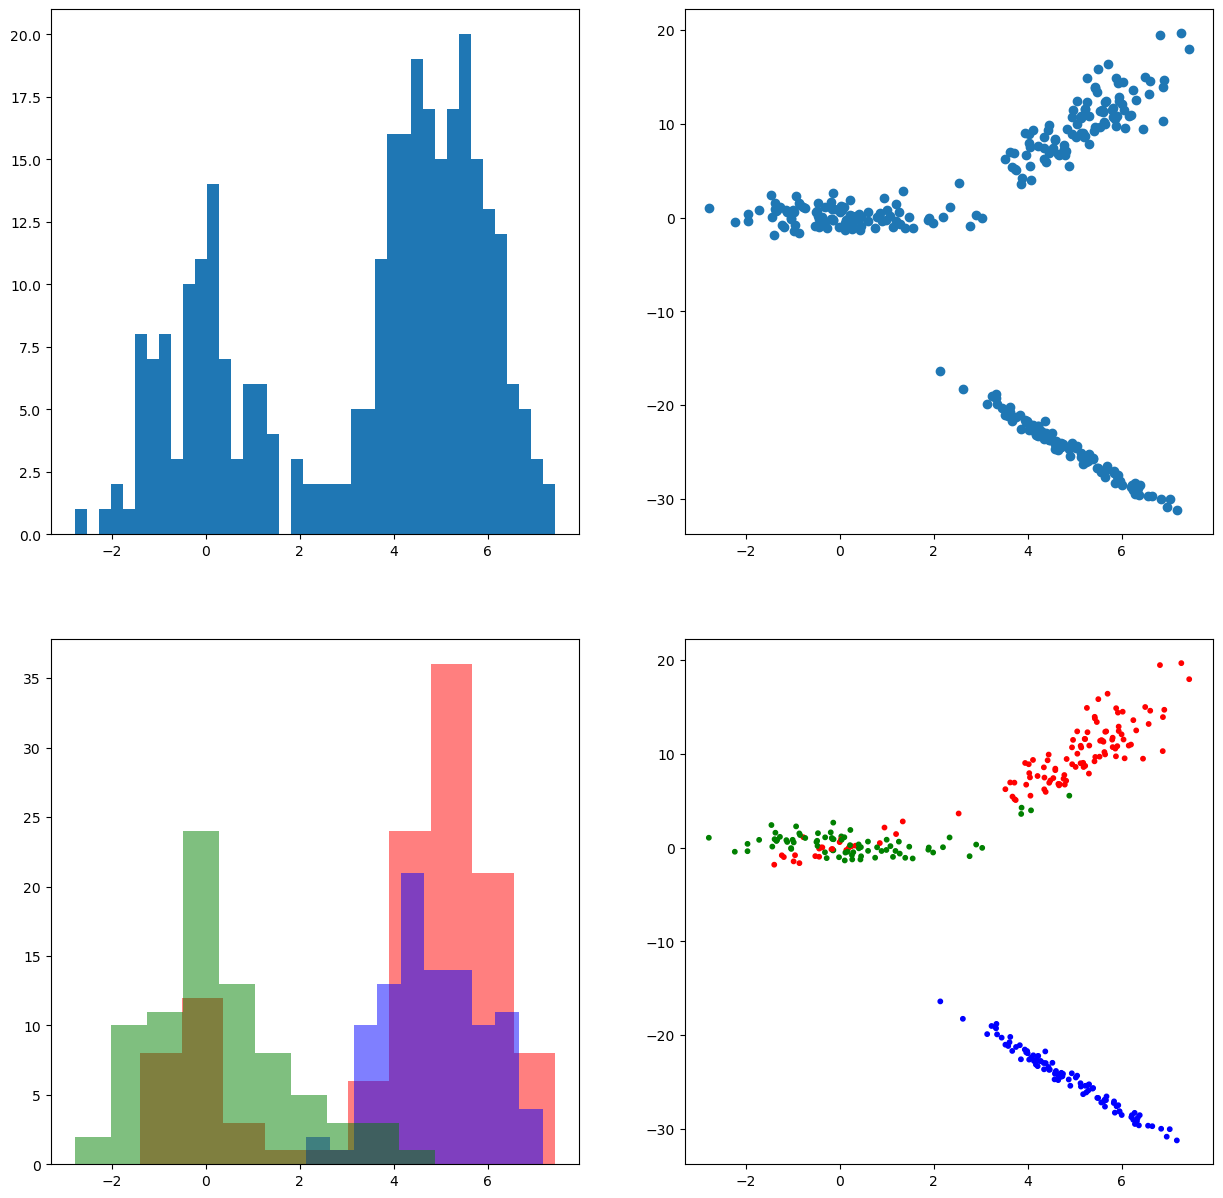

In [66]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].hist(Xs[:,1],bins=40)
ax[0,1].scatter(Xs[:,1],Ys)
inds = [0,1,2]
for i in inds:
    ax[1,0].hist(Xs[:,1][np.where(clust_labels_found==i)],
                 color=col_map[i],alpha=0.5)

ax[1,1].scatter(Xs[:,1],Ys,c=[col_map[i] for i in clust_labels_found],s=10)
plt.show()